# 1. Анализ структуры и предобработка данных

- знакомство с датасетом (`stage_2_detailed_class_info.csv`)
- исследование распределения классов и дисбаланса
- конвертация изображений из DICOM в PNG/JPEG
- визуализация примеров снимков по категориям
- парсинг мета информации из DICOM файлов
- клинический EDA (дополнительные срезы информации)

# Контроль запуска - первый запуск или нет

In [ ]:
IS_FIRST_RUN = True
SEED = 42

### Библиотеки

In [ ]:
import sys
from pathlib import Path # удобная работа с путями (совместима с Windows/Linux)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
# ----------------------------техническая строка-------------------------------
import pandas as pd                 # работа с табличными данными (DataFrame)
import matplotlib.pyplot as plt     # построение графиков и визуализация изображений
import seaborn as sns               # улучшенный стиль и функции визуализации поверх matplotlib

# src
from src.eda import (
    convert_dicom_folder_to_png,
    show_images_examples,
    dicom_meta_to_csv,
    parse_spacing
)

In [59]:
# базовая директория проекта (на уровень выше notebooks)
RAW_DIR = ROOT / 'data' / 'raw'
PROC_DIR = ROOT / 'data' / 'processed'

### Знакомство с датасетом

In [63]:
df_classes = pd.read_csv(RAW_DIR / 'stage_2_detailed_class_info.csv')
print(df_classes.head())
print(f'Количество записей в stage_2_detailed_class_info: {df_classes.shape}\n')
print('Количество фото в формате DICOM в папке stage_2_train_images:', len(list((RAW_DIR / 'stage_2_train_images').glob('*.dcm'))))

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
Количество записей в stage_2_detailed_class_info: (30227, 2)

Количество фото в формате DICOM в папке stage_2_train_images: 26684


В df_classes у нас 30227 записей. В папке stage_2_train_images лежит 26684 DICOM файлов. Разница скорее всего может объясняется тем, что в CSV в stage_2_detailed_class_info один и тот же patientId может встречаться несколько раз (например у снимка несколько разметок). В папке с изображениями stage_2_train_images находятся только уникальные снимки, поэтому файлов меньше. Проверим, есть ли дубликаты.

In [64]:
print('Уникальных patientId в df_classes:', df_classes['patientId'].nunique())
print('Дубликаты df_classes:', df_classes.duplicated().sum())

Уникальных patientId в df_classes: 26684
Дубликаты df_classes: 3543


Сравним уникальные id из таблицы и файлы из папки вдруг чего-то не хватает!

In [65]:
image_ids = set([f.stem for f in (RAW_DIR / 'stage_2_train_images').glob('*.dcm')])
csv_ids = set(df_classes['patientId'].unique())

print('Есть ли patientId без файлов:', len(csv_ids - image_ids))
print('Есть ли файлы без patientId в CSV:', len(image_ids - csv_ids))

Есть ли patientId без файлов: 0
Есть ли файлы без patientId в CSV: 0


Сократим таблицу до уникальных id.

In [66]:
df_classes = df_classes.drop_duplicates(subset='patientId')
print(df_classes.shape)

(26684, 2)


Теперь у нас чистый датафрейм. 26684 уникальных снимка, и для каждого определен ровно один класс. Это то, что нам и нужно для задачи классификации.

### Исследование распределения классов и дисбаланса

In [67]:
class_counts = df_classes['class'].value_counts()
print(class_counts)
print(round(class_counts / len(df_classes) * 100))

class
No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: count, dtype: int64
class
No Lung Opacity / Not Normal    44.0
Normal                          33.0
Lung Opacity                    23.0
Name: count, dtype: float64


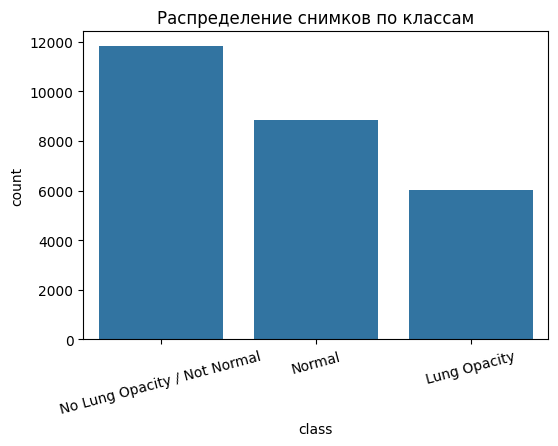

In [70]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df_classes, 
    x='class', 
    order=df_classes['class'].value_counts().index
)
plt.title('Распределение снимков по классам')
plt.xticks(rotation=15)
plt.show()

В нашем датасете всего уникальных снимков  26684.

Распределение классов:

- No Lung Opacity / Not Normal = 11 821 снимков (44%)
- Normal = 8 851 снимков (33%)
- Lung Opacity (пневмония) = 6 000 снимков (23%)

Датасет оказался несбалансированный, класс Lung Opacity (основной для задачи) встречается заметно реже, чем два других. Это важно учитывать при дальнейшем обучении модели.

### Конвертация изображений из DICOM в PNG/JPEG

Примечание: DICOM были преобразованы в PNG для удобства обучения моделей и визуализации. Это упрощает пайплайн, хотя может приводить к небольшой потере динамического диапазона. Для реальной медицины предпочтительно работать напрямую с DICOM!

In [ ]:
# Train
origin = RAW_DIR  / 'stage_2_train_images' # Директория откуда берем папка с DICOM снимками
target = PROC_DIR / 'train_png' # Директория куда кладем в папку train_png
target.mkdir(parents=True, exist_ok=True)

# Конвертируем файлы DICOM -> PNG
if IS_FIRST_RUN: 
    convert_dicom_folder_to_png(origin, target)

# Test
origin = RAW_DIR  / 'stage_2_test_images' # Директория откуда берем папка с DICOM снимками
target = PROC_DIR / 'test_png' # Директория куда кладем в папку train_png
target.mkdir(parents=True, exist_ok=True)

# Конвертируем файлы DICOM -> PNG
if IS_FIRST_RUN:
    convert_dicom_folder_to_png(origin, target)

Converting stage_2_test_images: 100%|██████████| 3001/3001 [04:25<00:00, 11.30it/s]

Готово: 3001 PNG сохранено в c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\test_png


### Визуализация примеров снимков по категориям

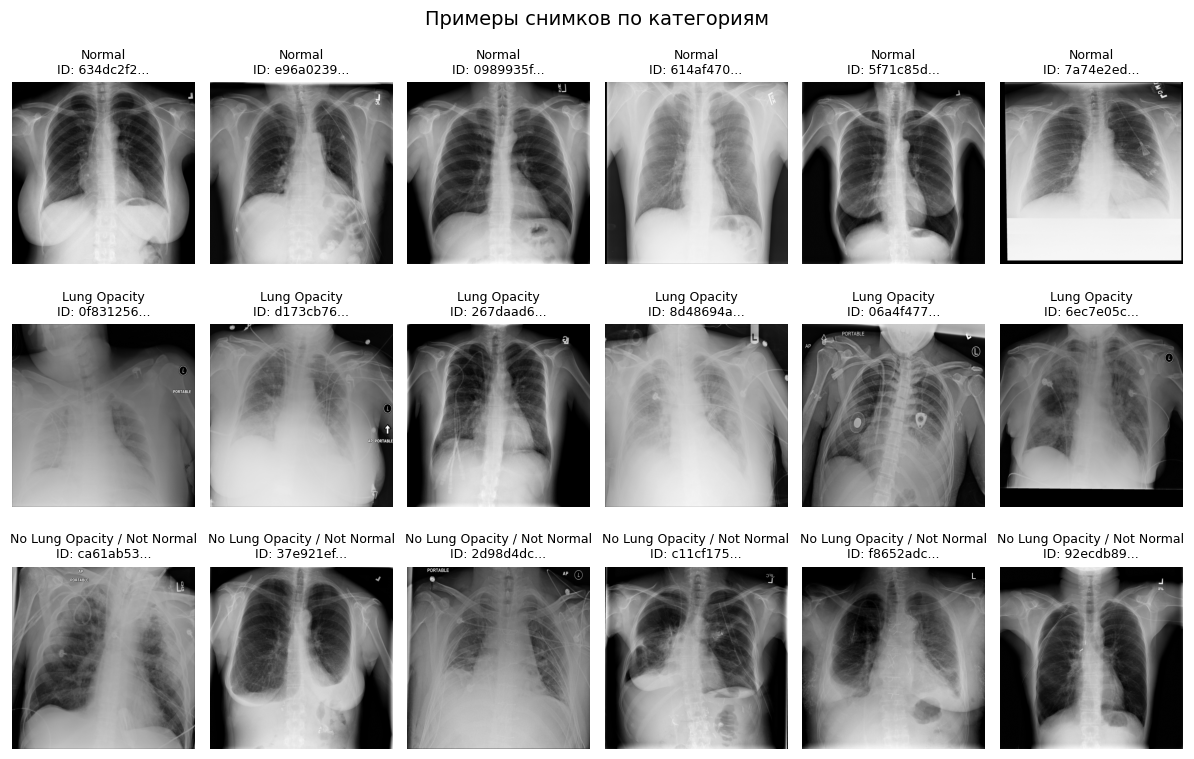

In [ ]:
# Пути
train_png = PROC_DIR / 'train_png'
# Классы
classes = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']

show_images_examples(png_location=train_png, # путь до train_png
                     df_classes=df_classes,
                     classes=classes,
                     seed=SEED, # Фиксируем seed для воспроизводимости
                     samples_per_class=6 # Сколько снимков на класс показываем
)

### Парсинг мета информации из DICOM -> CSV

In [ ]:
if IS_FIRST_RUN:
    train_dicom = RAW_DIR / 'stage_2_train_images'

    # Поля, которые будем извлекать
    fields = ['PatientID', 'PatientSex', 'PatientAge', 'ViewPosition', 'Rows', 'Columns', 'PixelSpacing']

    # Парсинг в датафрейм train
    meta_train_df = dicom_meta_to_csv(
        dcm_location=train_dicom, # Путь к файлам dicom
        fields=fields # Поля которые парсим
    )

    # Объединим с основным датасетом
    df_meta_train_merged = df_classes.merge(
        meta_train_df,
        on='patientId', 
        how='left'
    )

    df_meta_train_merged.head()

    # Сохраним результаты парсинга в папку processed
    meta_path = PROC_DIR / 'meta_train_info.csv'
    df_meta_train_merged.to_csv(meta_path, index=False)

Парсим DICOM метаинформацию: 100%|██████████| 26684/26684 [00:21<00:00, 1240.68it/s]


Мы получили полный датасет (тренировочный) для дальнейшей работы. Теперь проводим его анализ.

Примечание: Тестовый датасет используется на финальной стадии тестирования моделей!

Дата сет состоит из следующих признаков:
- patientId - идентификатор клиента обезличенный (закодированы имя, фамилия, отчество)
- sex - пол пациента
- age - возраст пациента
- view_position - два основных типа укладки (передне-задняя и задне-передняя проекции)
- rows / cols - размер матрицы изображения (в пикселях)
- pixel_spacing - физический размер пикселя (в миллиметрах) в формате [dx, dy]
- class - класс состояния легких (целевая переменная):

* *Normal* - норма;
* *No Lung Opacity / Not Normal* - патологические изменения, но не пневмония;
* *Lung Opacity* - пневмония обнаружена.

In [36]:
meta_path = PROC_DIR / 'meta_train_info.csv'
df_meta_merged = pd.read_csv(meta_path)

print(f'Общая информация:')
df_meta_merged.info()

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patientId      26684 non-null  object 
 1   class          26684 non-null  object 
 2   sex            26684 non-null  object 
 3   age            26679 non-null  float64
 4   view_position  26684 non-null  object 
 5   rows           26684 non-null  int64  
 6   cols           26684 non-null  int64  
 7   pixel_spacing  26684 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.6+ MB


In [37]:
print(f'Количество уникальных значений в группах: \n{df_meta_merged[['sex', 'view_position', 'class']].nunique()}\n')
print(f'Информация по распределениям: ')
df_meta_merged.describe(include='all').T

Количество уникальных значений в группах: 
sex              2
view_position    2
class            3
dtype: int64

Информация по распределениям: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,26684,26684,c1f7889a-9ea9-4acb-b64c-b737c929599a,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,26684,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,26684,2,M,15166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,26679.0,NaN,NaN,NaN,47.010458,16.751282,1.0,34.0,49.0,59.0,92.0
view_position,26684,2,PA,14511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rows,26684.0,NaN,NaN,NaN,1024.0,0.0,1024.0,1024.0,1024.0,1024.0,1024.0
cols,26684.0,NaN,NaN,NaN,1024.0,0.0,1024.0,1024.0,1024.0,1024.0,1024.0
pixel_spacing,26684,18,"[0.14300000000000002, 0.14300000000000002]",8993,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Снова проверим на пропуски.

In [38]:
print(f'До проверки: {df_meta_merged.isnull().sum()}')
df_meta_merged['age'] = df_meta_merged['age'].astype(float)
df_meta_merged.loc[df_meta_merged['age'].isna(), 'age'] = df_meta_merged['age'].median() # Заполним пропуски медианой (поскольку их немного)
print(f'После проверки: {df_meta_merged.isnull().sum()}')

До проверки: patientId        0
class            0
sex              0
age              5
view_position    0
rows             0
cols             0
pixel_spacing    0
dtype: int64
После проверки: patientId        0
class            0
sex              0
age              0
view_position    0
rows             0
cols             0
pixel_spacing    0
dtype: int64


Проведем кодирование, приведение к типам

In [39]:
# One-Hot-Encoding для пола
df_meta_merged['sex'] = df_meta_merged['sex'].fillna('Unknown')  # если есть пропуски
sex_dummies = pd.get_dummies(df_meta_merged['sex'], prefix='sex')
df_meta_merged = pd.concat([df_meta_merged, sex_dummies], axis=1)

# One-Hot-Encoding для позиции снимка
df_meta_merged['view_position'] = df_meta_merged['view_position'].fillna('Unknown')
vp_dummies = pd.get_dummies(df_meta_merged['view_position'], prefix='vp')
df_meta_merged = pd.concat([df_meta_merged, vp_dummies], axis=1)

# Парсим pixel_spacing в два отдельных признака (float)
df_meta_merged['pixel_spacing'] = df_meta_merged['pixel_spacing'].fillna('[0, 0]')

df_meta_merged['spacing_x'], df_meta_merged['spacing_y'] = zip(*df_meta_merged['pixel_spacing'].map(parse_spacing))

# Удаляем исходные столбцы, которые уже закодированы или заменены
df_meta_merged = df_meta_merged.drop(columns=['sex', 'view_position', 'pixel_spacing'])

# Проверяем результат
df_meta_merged.info()
df_meta_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  26684 non-null  object 
 1   class      26684 non-null  object 
 2   age        26684 non-null  float64
 3   rows       26684 non-null  int64  
 4   cols       26684 non-null  int64  
 5   sex_F      26684 non-null  bool   
 6   sex_M      26684 non-null  bool   
 7   vp_AP      26684 non-null  bool   
 8   vp_PA      26684 non-null  bool   
 9   spacing_x  26684 non-null  float64
 10  spacing_y  26684 non-null  float64
dtypes: bool(4), float64(3), int64(2), object(2)
memory usage: 1.5+ MB


,patientId,class,age,rows,cols,sex_F,sex_M,vp_AP,vp_PA,spacing_x,spacing_y
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51.0,1024,1024,True,False,False,True,0.143000,0.143000
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48.0,1024,1024,True,False,False,True,0.194311,0.194311
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19.0,1024,1024,False,True,True,False,0.168000,0.168000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28.0,1024,1024,False,True,False,True,0.143000,0.143000
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32.0,1024,1024,True,False,True,False,0.139000,0.139000


Сохраняем предобработанный датасет

In [ ]:
if IS_FIRST_RUN:
    meta_path = PROC_DIR / 'meta_info_encoded.csv'
    df_meta_merged.to_csv(meta_path, index=False)

Итоговый объединенный датафрейм содержит 26684 наблюдения, каждое из которых соответствует одному рентгеновскому снимку грудной клетки.
В таблице представлены демографические и технические признаки пациентов, а также класс заболевания, что позволяет проводить как визуальный анализ, так и строить мультимодальные модели (изображение + табличные данные).

### Клинический EDA (дополнительные срезы информации)

На основе полученного расширенного meta_info_encoded.csv можно провести дополнительные исследования четырех ключевых срезов:

#### 1. Распределение возраста по классам заболеваний

- Проверим, как часто встречаются пневмонии у разных возрастных групп.

#### 2. Распределение пола (м/ж) по классам

- Есть ли дисбаланс по полу (например, у мужчин чаще пневмония и наоборот)?

#### 3. Совместное распределение возраста и пола

- Например, молодые мужчины против пожилых женщин.

#### 4. Распределение типов снимков (view_position) по классам

- Понять, не является ли тип укладки (PA/AP) косвенным индикатором класса.

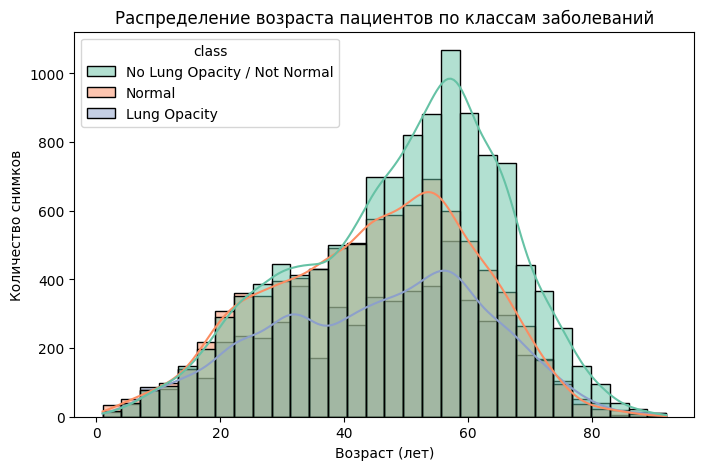

In [41]:
meta_path = PROC_DIR / 'meta_info_encoded.csv'
df_meta_encoded = pd.read_csv(meta_path)

# Распределение возраста по классам
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_meta_encoded, 
    x='age', 
    hue='class', 
    bins=30, 
    kde=True, 
    palette='Set2'
)
plt.title('Распределение возраста пациентов по классам заболеваний')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество снимков')
plt.show()

На графике видно, что в данных представлены пациенты практически всех возрастных групп - от младенцев до пожилых людей (1–85 лет).
Количество снимков растет по мере увеличения возраста, достигая пика примерно в возрасте 55–65 лет.
Для здоровых пациентов (Normal) наблюдается выраженный пик около 55 лет.
Для пациентов с пневмонией (Lung Opacity) выявляются два возрастных пика:

- около 30 лет,

- в районе 60 лет, где также фиксируется рост других заболеваний легких (No Lung Opacity / Not Normal).

Такая закономерность указывает, что возраст является важным признаком для анализа и последующего моделирования: риск патологий легких, включая пневмонию, возрастает с возрастом пациента.

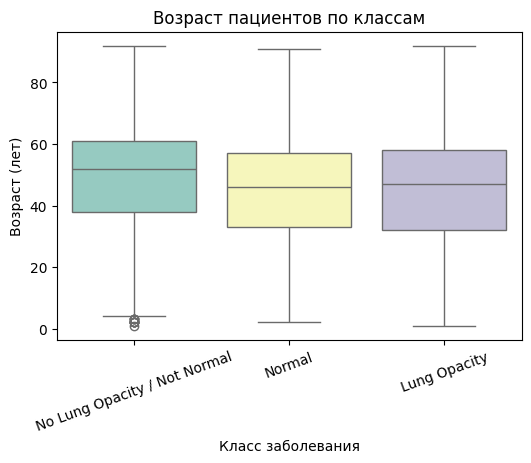

In [42]:
# Возраст по классам 
plt.figure(figsize=(6,4)) 
sns.boxplot(
    data=df_meta_encoded, 
    x='class', 
    y='age',
    hue='class',
    palette='Set3'
    ) 
plt.title('Возраст пациентов по классам') 
plt.xlabel('Класс заболевания') 
plt.ylabel('Возраст (лет)') 
plt.xticks(rotation=20) 
plt.show()

На диаграмме размаха видно, что возрастное распределение пациентов во всех трех классах достаточно близко, однако присутствуют небольшие различия в медианных значениях.

- Здоровые пациенты (Normal) имеют медианный возраст около 55 лет.
- Пациенты с другими заболеваниями легких (No Lung Opacity / Not Normal) - около 58 лет.
- Пациенты с пневмонией (Lung Opacity) - примерно 56–57 лет.

Таким образом, можно сделать вывод, что пороговый возраст около 55 лет является условной границей, после которой риск заболеваний легких начинает заметно возрастать.
Это подтверждает предположение о значимости признака возраста для дальнейшего моделирования и классификации снимков.

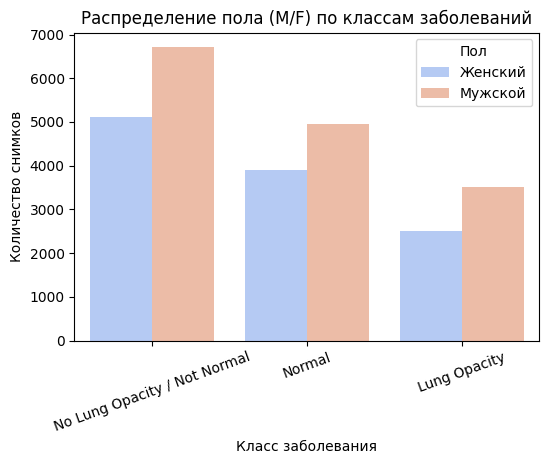

In [43]:
# Распределение по полу (м/ж) и классам
plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_meta_encoded, 
    x='class', 
    hue='sex_M', 
    palette='coolwarm'
)
plt.title('Распределение пола (M/F) по классам заболеваний')
plt.xlabel('Класс заболевания')
plt.ylabel('Количество снимков')
plt.xticks(rotation=20)
# Меняем подписи в легенде
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Женский', 'Мужской'], title='Пол')
plt.show()

На графике видно, что во всех категориях наблюдается преобладание пациентов мужского пола.

- Среди здоровых пациентов (Normal) доля мужчин заметно выше, чем женщин, что указывает на неравномерное распределение данных по половому признаку.
- Для групп с другими заболеваниями легких (No Lung Opacity / Not Normal) и с пневмонией (Lung Opacity) также преобладают мужчины.

Таким образом, можно заключить, что в выборке наблюдается гендерный дисбаланс: снимков мужских пациентов больше, чем женских.
Это следует учитывать при моделировании, чтобы избежать смещения модели по половому признаку.

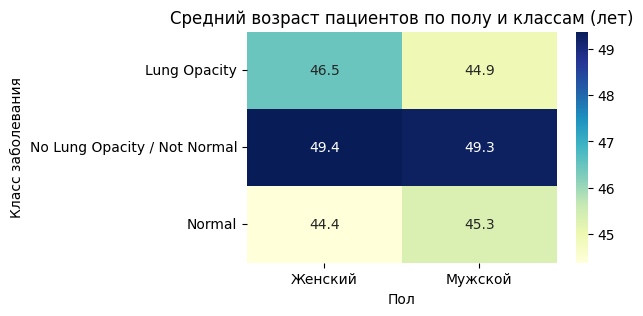

In [44]:
# Возраст + пол: зависимость
pivot = df_meta_encoded.pivot_table(
    index='class', columns='sex_M', values='age', aggfunc='mean'
)
pivot.columns = ['Женский','Мужской']

plt.figure(figsize=(5,3))
sns.heatmap(data=pivot, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu'
)
plt.title('Средний возраст пациентов по полу и классам (лет)')
plt.xlabel('Пол')
plt.ylabel('Класс заболевания')
plt.show()

Согласно тепловой карте, средний возраст здоровых пациентов (Normal) составляет около 45 лет у мужчин и 44 лет у женщин.

- Для группы пациентов с другими заболеваниями легких (No Lung Opacity / Not Normal) средний возраст заметно выше - примерно 49 лет как у мужчин, так и у женщин.
- Среди пациентов с пневмонией (Lung Opacity) наблюдается небольшая разница между полами: женщины в среднем старше (примерно 46 лет), чем мужчины (≈45 лет).

Таким образом, в группу повышенного риска по заболеваниям легких попадают пациенты в возрасте от 45 до 50 лет, независимо от пола.
Это подтверждает значимость признака возраста при анализе и прогнозировании состояния легких.

- PA Posterior–Anterior	(Передне-задняя укладка) - Рентгеновский луч проходит сзади -> вперед. Пациент стоит лицом к кассете, спиной к аппарату.

- AP Anterior–Posterior	(Задне-передняя укладка) - Луч проходит спереди -> назад. Пациент обычно лежит (например, в больнице или реанимации). Используется для тяжелых или маломобильных пациентов, часто при подозрении на пневмонию.

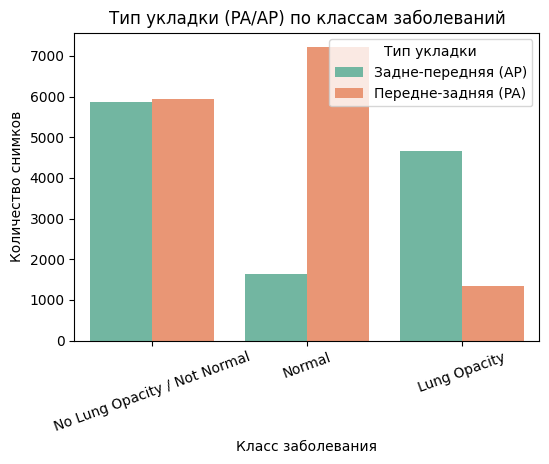

In [45]:
# Тип укладки снимка по классам
plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_meta_encoded, 
    x='class', 
    hue='vp_PA',
    palette='Set2'
)
plt.title('Тип укладки (PA/AP) по классам заболеваний')
plt.xlabel('Класс заболевания')
plt.ylabel('Количество снимков')
plt.xticks(rotation=20)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Задне-передняя (AP)', 'Передне-задняя (PA)'], title='Тип укладки')
plt.show()

На графике видно, что среди здоровых пациентов (Normal) доминирует передне-задняя укладка (PA) - это соответствует стандартной практике, когда снимок выполняется в положении стоя.

Для пациентов с пневмонией (Lung Opacity), напротив, преобладает задне-передняя укладка (AP), что косвенно указывает на тяжелое состояние пациентов, при котором обследование проводится в положении лежа.

В группе с другими патологиями легких (No Lung Opacity / Not Normal) распределение между типами укладки более сбалансировано, с небольшим перевесом в сторону стандартной PA-проекции.

Таким образом, тип укладки может отражать физиологическое состояние пациента и должен учитываться при интерпретации результатов и обучении модели, чтобы избежать ложных корреляций между положением пациента и диагнозом.

### Проверка на корреляции

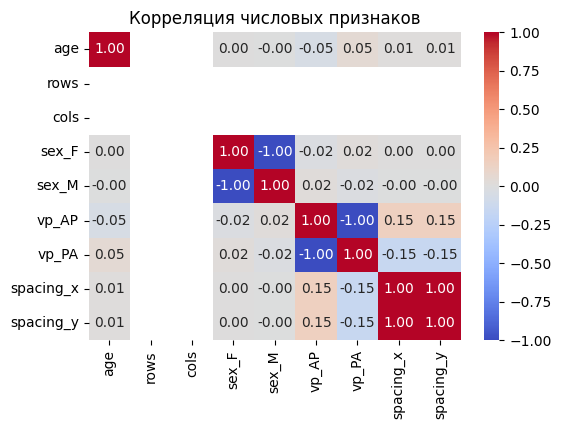

In [46]:
# Дополнительно проверим на корреляцию признаков
plt.figure(figsize=(6,4))
sns.heatmap(
    df_meta_encoded.corr(numeric_only=True), 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm'
)
plt.title('Корреляция числовых признаков')
plt.show()

Проведенный анализ показал отсутствие мультиколлинеарности между признаками.
Исключительно технические корреляции наблюдаются между бинарными one-hot признаками (sex_F / sex_M, vp_AP / vp_PA), что является нормой.
Данные очищены, признаки независимы, и могут быть использованы для построения baseline-модели без дополнительной фильтрации. Удалять их не будем, просто вернемся к этому этапу во время обучения модели на **meta признаках**.

Таким образом этап EDA завершен.